# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [1]:
### IMPORTS ###
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch.nn as nn
import numpy as np
import os, json
import torch
from torchvision import models, transforms, datasets
from torch.autograd import Variable
import torch.nn.functional as F
from skimage.segmentation import watershed, mark_boundaries
from skimage.filters import sobel
from skimage.color import rgb2gray
from lime import lime_image, scikit_image_wrapper
from pathlib import Path
from utils.mnist_helpers import MNIST_CNN

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
DATA_PATH = ROOT_DIR / 'data'
MNIST_PATH = DATA_PATH / 'MNIST'
MNIST_TRAINED_WEIGHTS = MNIST_PATH / 'mnist_cnn.pt'

### PYTORCH SETTINGS ###
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### FUNCTIONS ###
def get_datasets():
    train_dataset = datasets.MNIST(DATA_PATH, train=True, download=True)
    test_dataset = datasets.MNIST(DATA_PATH, train=False)
    return train_dataset, test_dataset

def get_image(dataset):
    #randomly pick a image from image folder
    index = random.randint(0, len(dataset))
    img = transforms.functional.to_pil_image(dataset.data[index])
    return img

def get_preprocess_transform():
    normalize = transforms.Normalize((0.1307,), (0.3081,))   
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

def batch_predict(images):
    model.eval()
    # [:,:,0] converts back to grayscale
    batch = torch.stack(tuple(preprocess_transform(i[:,:,0]) for i in images), dim=0)

    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


Device: cuda


In [2]:
# Get datasets
train_dataset, test_dataset = get_datasets()

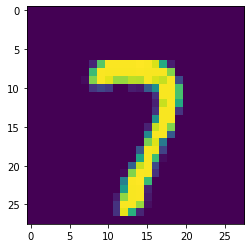

In [3]:
#display a image
img = get_image(train_dataset)
plt.imshow(img)

# BLACK BOX CLASSIFIER

tensor([[-26.4668, -32.4981, -16.6118, -26.5634, -28.3766, -30.0724, -30.7033,
         -33.7450,   7.7618, -27.3506]])
Prediction: 8


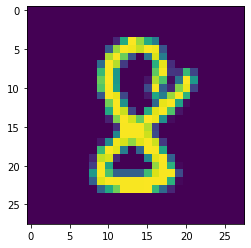

In [4]:
#same architecture used as https://github.com/amitrajitbose/cat-v-dog-classifier-pytorch
model = MNIST_CNN()

#load model weights from black box training (Train loss: 0.109.. Test loss: 0.031.. Test accuracy: 0.988)
model.load_state_dict(torch.load(MNIST_TRAINED_WEIGHTS, map_location=device))
model.eval()

#test prediction
img = get_image(test_dataset)
preprocess_transform = get_preprocess_transform()
out = model(torch.unsqueeze(preprocess_transform(np.array(img)), dim=0))
class_idx = torch.max(F.softmax(out, dim=1), dim=1).indices
plt.imshow(img)
print(out)
print(f"Prediction: {class_idx.item()}")

# LIME

In [33]:
#segmentation_fn = lambda img: watershed(sobel(rgb2gray(img)), markers=200)
segmentation_fn = lambda img: np.arange(img.shape[0]*img.shape[1]).reshape(img.shape[:2]) # individual pixels

In [34]:
### LIME ###
#LIME code taken and modified from https://github.com/marcotcr/lime
explainer = lime_image.LimeImageExplainer(kernel_width=0.25, verbose=True)
explanation = explainer.explain_instance(np.array(img), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=100000,
                                         segmentation_fn = segmentation_fn) # number of images that will be sent to classification function

  0%|          | 0/100000 [00:00<?, ?it/s]

Intercept 0.46846778394211214
Prediction_local [-0.11164728]
Right: 2.5983288e-11
Intercept -1.147656533058789
Prediction_local [2.03200206]
Right: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


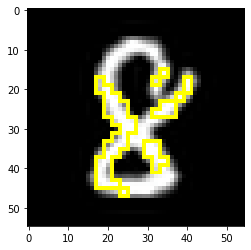

In [44]:
#Visualizing explained features 
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=50, hide_rest=False)
img_boundry1 = mark_boundaries(temp, mask, mode='subpixel')
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


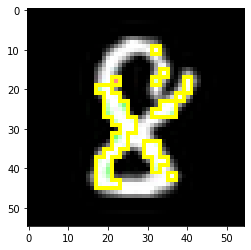

In [45]:
#Visualizing explained features with coloring (green= areas contributing for top prediction red=areas contributing against top prediction)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False)
img_boundry2 = mark_boundaries(temp, mask, mode='subpixel')
plt.imshow(img_boundry2)